In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production solaire** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (soleil).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_3H.csv',
                usecols = ['Dates', 'Solaire'])
df.head(1)

,Dates,Solaire
0,2013-01-01 00:00:00,0.0


In [3]:
df.shape

(25808, 2)

In [4]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [5]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [6]:
capa = pd.read_csv('./datasource/capacite_solaire_FR.csv',
                  usecols = ['Dates', 'Capa_sol'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [7]:
capa.shape

(25808, 1)

In [8]:
df = pd.concat([df, capa], axis = 1)
df['TCH_sol'] = df['Solaire'] / df['Capa_sol']
df

,Solaire,Capa_sol,TCH_sol
Dates,,,
2013-01-01 00:00:00,0.000000,3644,0.000000
2013-01-01 03:00:00,0.000000,3644,0.000000
2013-01-01 06:00:00,0.000000,3644,0.000000
2013-01-01 09:00:00,193.333333,3644,0.053055
2013-01-01 12:00:00,555.333333,3644,0.152397
...,...,...,...
2021-10-31 09:00:00,2709.166667,12469,0.217272
2021-10-31 12:00:00,3652.666667,12469,0.292940
2021-10-31 15:00:00,1021.666667,12469,0.081937


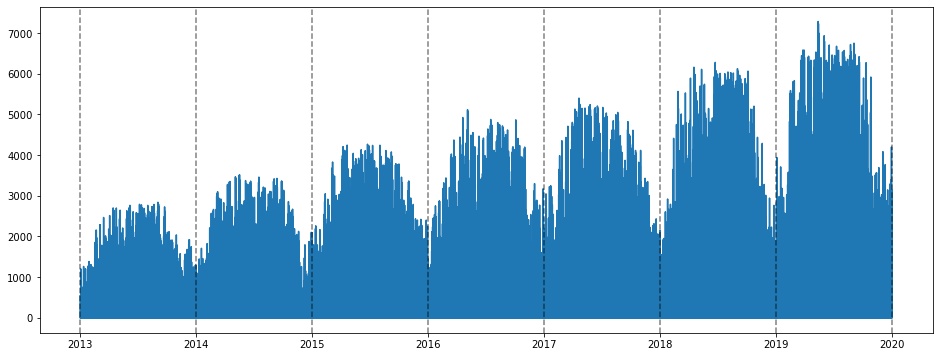

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['Solaire'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

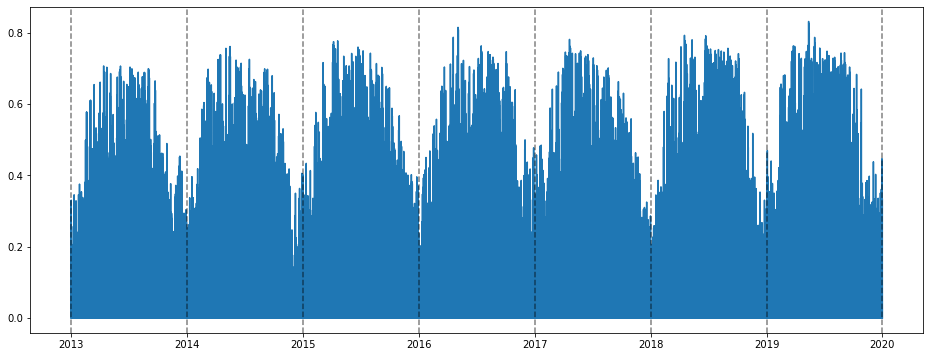

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_sol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

### Test de stationnarité

In [11]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_sol'])

(-6.689281561767071,
 4.149031472308638e-09,
 49,
 25758,
 {'1%': -3.4306038998292085,
  '5%': -2.8616522161827964,
  '10%': -2.566829729367711},
 -103671.06251774792)

### Coéfficients SARIMAX et saisonnalités

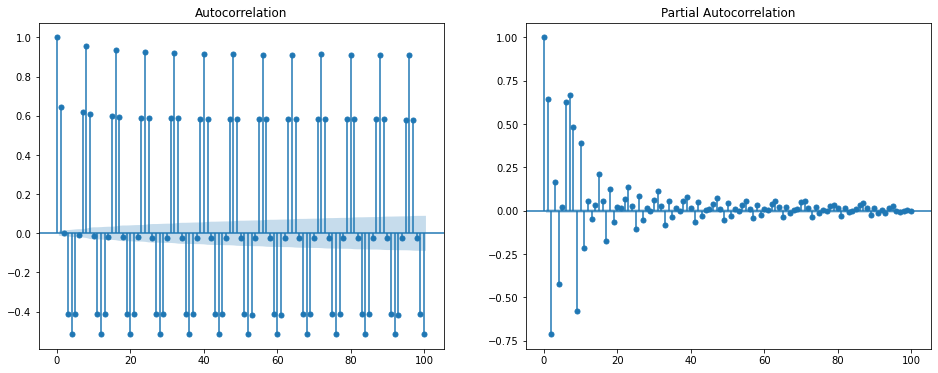

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_sol'], lags = 100, ax=ax1)
plot_pacf(df['TCH_sol'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 1 an

# Import du dataset filtré (Transformation de Fourier)

In [13]:
df_filtered = pd.read_csv('./dataset/France_3H_filtered.csv',
                usecols = ['Dates', 'Solaire'])
df_filtered.head(1)

,Dates,Solaire
0,2013-01-01 00:00:00,73.165713


In [14]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [15]:
df_filtered = pd.concat([df_filtered, capa], axis = 1)
df_filtered['TCH_sol'] = df_filtered['Solaire'] / df_filtered['Capa_sol']

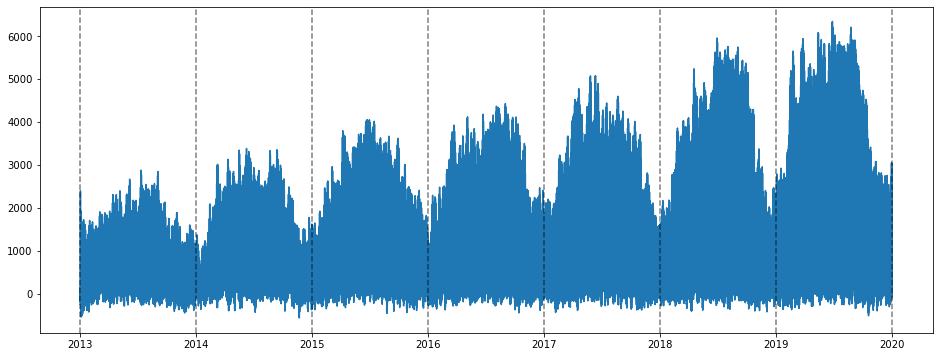

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['Solaire'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

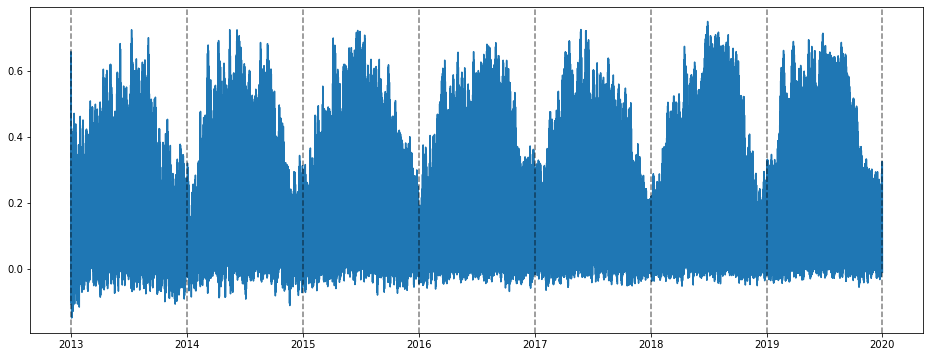

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['TCH_sol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

# Jeux d'entrainement et de test

In [18]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [19]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [20]:
fenetre = df_test.shape[0]

In [21]:
indice = df_test.index

In [22]:
bilan = df_test

# Paramètres SARIMAX

In [23]:
ordre = (3,0,0)
saison = (2,0,0,8)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [24]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
# exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
# exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25)
exog.set_index('date', inplace = True)

In [25]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-26-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

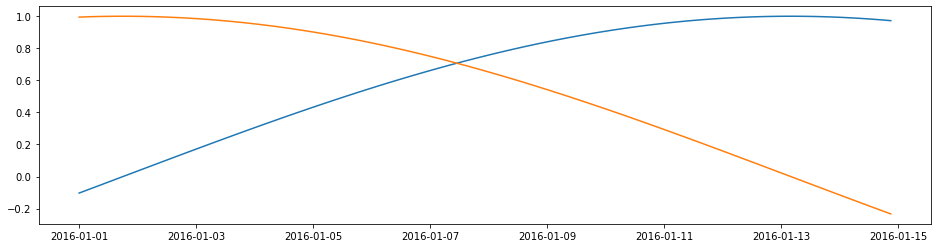

In [26]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [27]:
model_sinus = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [29]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Sol_p_sinus'], index = indice)

In [30]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [31]:
bilan['Err_sinus'] = np.abs(bilan['Sol_p_sinus'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03
mean,1571.800218,10519.437313,0.148462,0.140935,1.210351e-01
std,2114.541475,893.727751,0.198264,0.189979,1.306124e-01
min,0.000000,9414.000000,0.000000,-0.101192,1.668555e-07
25%,1.000000,9791.000000,0.000098,0.000557,7.723424e-03
50%,255.083333,10167.000000,0.024076,0.027594,6.774353e-02
75%,2842.416667,11241.000000,0.274220,0.263836,2.072380e-01
max,8662.666667,12469.000000,0.755672,0.756843,5.921407e-01


# Régresseurs exogènes : données métier

In [32]:
exog = pd.read_csv('./exog/exog_3H_FR.csv', sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01 00:00:00,8.05


In [33]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [34]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [35]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [36]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               39528.176
Date:                           Wed, 04 May 2022   AIC                         -79042.353
Time:                                   10:24:14   BIC                         -78986.873
Sample:                                        0   HQIC                        -79024.221
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0123      0.002      8.145      0.000       0.009       0.015
ar.L1          1.1466      0.007    168.197      0.000       1.133       1.160
ar.L2         -0.7164      0.009    -77.385      0.000      -0.734      -0.698
ar.L3          0.2407      0.007     35.444      0.000       0.227       0.254
ar.S.L8        0.6664      0.007     99.250      0.000       0.653       0.680
ar.S.L16       0.2951      0.007     43.983      0.000       0.282       0.308
sigma2         0.0012   1.21e-05    101.142      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   7.15   Jarque-Bera (JB):             30691.43
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [38]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [39]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Sol_p_exog'])

In [40]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [41]:
bilan['Err_exog'] = np.abs(bilan['Sol_p_exog'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000
mean,1571.800218,10519.437313,0.148462,0.140935,1.210351e-01,0.142612,0.120919
std,2114.541475,893.727751,0.198264,0.189979,1.306124e-01,0.189619,0.129898
min,0.000000,9414.000000,0.000000,-0.101192,1.668555e-07,-0.098770,0.000007
25%,1.000000,9791.000000,0.000098,0.000557,7.723424e-03,0.002335,0.008202
50%,255.083333,10167.000000,0.024076,0.027594,6.774353e-02,0.029747,0.067625
75%,2842.416667,11241.000000,0.274220,0.263836,2.072380e-01,0.265010,0.205856
max,8662.666667,12469.000000,0.755672,0.756843,5.921407e-01,0.757849,0.588841


# Régresseurs exogènes : données métier FILTREES

In [42]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01 00:00:00,8.05


In [43]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [44]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [45]:
model_filter = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [46]:
result_filter = model_filter.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               39528.177
Date:                           Wed, 04 May 2022   AIC                         -79042.353
Time:                                   10:26:15   BIC                         -78986.874
Sample:                                        0   HQIC                        -79024.222
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0123      0.002      8.143      0.000       0.009       0.015
ar.L1          1.1464      0.007    168.174      0.000       1.133       1.160
ar.L2         -0.7162      0.009    -77.363      0.000      -0.734      -0.698
ar.L3          0.2407      0.007     35.442      0.000       0.227       0.254
ar.S.L8        0.6664      0.007     99.251      0.000       0.653       0.680
ar.S.L16       0.2951      0.007     43.984      0.000       0.282       0.308
sigma2         0.0012   1.21e-05    101.142      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   7.27   Jarque-Bera (JB):             30700.48
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [48]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [49]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Sol_p_filter'])

In [50]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [51]:
bilan['Err_exog_filter'] = np.abs(bilan['Sol_p_filter'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000
mean,1571.800218,10519.437313,0.148462,0.140935,1.210351e-01,0.142612,0.120919,0.142612,0.120919
std,2114.541475,893.727751,0.198264,0.189979,1.306124e-01,0.189619,0.129898,0.189618,0.129899
min,0.000000,9414.000000,0.000000,-0.101192,1.668555e-07,-0.098770,0.000007,-0.098757,0.000005
25%,1.000000,9791.000000,0.000098,0.000557,7.723424e-03,0.002335,0.008202,0.002335,0.008200
50%,255.083333,10167.000000,0.024076,0.027594,6.774353e-02,0.029747,0.067625,0.029747,0.067633
75%,2842.416667,11241.000000,0.274220,0.263836,2.072380e-01,0.265010,0.205856,0.265011,0.205854
max,8662.666667,12469.000000,0.755672,0.756843,5.921407e-01,0.757849,0.588841,0.757848,0.588852


# Target FILTREE sans régresseur

### SARIMAX

In [52]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter['TCH_sol'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [53]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               93074.757
Date:                           Wed, 04 May 2022   AIC                        -186137.513
Time:                                   10:27:02   BIC                        -186089.959
Sample:                                        0   HQIC                       -186121.972
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3107      0.004    609.552      0.000       2.303       2.318
ar.L2         -2.1941      0.007   -337.360      0.000      -2.207      -2.181
ar.L3          0.8597      0.004    232.427      0.000       0.852       0.867
ar.S.L8        1.6128      0.006    289.392      0.000       1.602       1.624
ar.S.L16      -0.6188      0.006   -111.267      0.000      -0.630      -0.608
sigma2      6.444e-06   7.62e-08     84.590      0.000    6.29e-06    6.59e-06
===================================================================================
Ljung-Box (L1) (Q):                5039.02   Jarque-Bera (JB):             30946.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [55]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [56]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Sol_p_reduit_noreg'])

In [57]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [58]:
bilan['Err_filter_noreg'] = np.abs(bilan['Sol_p_reduit_noreg'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,1571.800218,10519.437313,0.148462,0.140935,1.210351e-01,0.142612,0.120919,0.142612,0.120919,0.143169,0.129572
std,2114.541475,893.727751,0.198264,0.189979,1.306124e-01,0.189619,0.129898,0.189618,0.129899,0.191487,0.124259
min,0.000000,9414.000000,0.000000,-0.101192,1.668555e-07,-0.098770,0.000007,-0.098757,0.000005,-0.192808,0.000027
25%,1.000000,9791.000000,0.000098,0.000557,7.723424e-03,0.002335,0.008202,0.002335,0.008200,0.000106,0.025872
50%,255.083333,10167.000000,0.024076,0.027594,6.774353e-02,0.029747,0.067625,0.029747,0.067633,0.047412,0.078840
75%,2842.416667,11241.000000,0.274220,0.263836,2.072380e-01,0.265010,0.205856,0.265011,0.205854,0.276568,0.213246
max,8662.666667,12469.000000,0.755672,0.756843,5.921407e-01,0.757849,0.588841,0.757848,0.588852,0.730137,0.575517


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [59]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01 00:00:00,8.05


In [60]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [61]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [62]:
model_reduit = sm.tsa.SARIMAX(df_train_filter['TCH_sol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [63]:
result_reduit = model_reduit.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                20448
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 8)   Log Likelihood               90950.158
Date:                           Wed, 04 May 2022   AIC                        -181886.316
Time:                                   10:29:08   BIC                        -181830.837
Sample:                                        0   HQIC                       -181868.184
                                         - 20448                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.001      0.396      0.692      -0.002       0.003
ar.L1          2.2664      0.005    477.225      0.000       2.257       2.276
ar.L2         -2.1088      0.008   -258.534      0.000      -2.125      -2.093
ar.L3          0.8235      0.004    185.941      0.000       0.815       0.832
ar.S.L8        1.6816      0.006    269.999      0.000       1.669       1.694
ar.S.L16      -0.6915      0.006   -111.291      0.000      -0.704      -0.679
sigma2      7.967e-06   1.41e-07     56.514      0.000    7.69e-06    8.24e-06
===================================================================================
Ljung-Box (L1) (Q):                3428.46   Jarque-Bera (JB):             29946.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [65]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [66]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Sol_p_reduit'])

In [67]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [68]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Sol_p_reduit'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,1571.800218,10519.437313,0.148462,0.140935,1.210351e-01,0.142612,0.120919,0.142612,0.120919,0.143169,0.129572,0.143161,0.129544
std,2114.541475,893.727751,0.198264,0.189979,1.306124e-01,0.189619,0.129898,0.189618,0.129899,0.191487,0.124259,0.191592,0.124128
min,0.000000,9414.000000,0.000000,-0.101192,1.668555e-07,-0.098770,0.000007,-0.098757,0.000005,-0.192808,0.000027,-0.194508,0.000022
25%,1.000000,9791.000000,0.000098,0.000557,7.723424e-03,0.002335,0.008202,0.002335,0.008200,0.000106,0.025872,-0.000064,0.026002
50%,255.083333,10167.000000,0.024076,0.027594,6.774353e-02,0.029747,0.067625,0.029747,0.067633,0.047412,0.078840,0.047250,0.078850
75%,2842.416667,11241.000000,0.274220,0.263836,2.072380e-01,0.265010,0.205856,0.265011,0.205854,0.276568,0.213246,0.275916,0.213405
max,8662.666667,12469.000000,0.755672,0.756843,5.921407e-01,0.757849,0.588841,0.757848,0.588852,0.730137,0.575517,0.731141,0.576829


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [69]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01 00:00:00,8.05


In [70]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [71]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [72]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_sol'])
predict_lr = LinReg.predict(exog_test)

In [73]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Sol_p_LinReg'])

In [74]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [75]:
bilan['Err_LinReg'] = np.abs(bilan['Sol_p_LinReg'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter,Sol_p_LinReg,Err_LinReg
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,1571.800218,10519.437313,0.148462,0.140935,1.210351e-01,0.142612,0.120919,0.142612,0.120919,0.143169,0.129572,0.143161,0.129544,0.152264,0.159971
std,2114.541475,893.727751,0.198264,0.189979,1.306124e-01,0.189619,0.129898,0.189618,0.129899,0.191487,0.124259,0.191592,0.124128,0.055982,0.103948
min,0.000000,9414.000000,0.000000,-0.101192,1.668555e-07,-0.098770,0.000007,-0.098757,0.000005,-0.192808,0.000027,-0.194508,0.000022,0.058997,0.000022
25%,1.000000,9791.000000,0.000098,0.000557,7.723424e-03,0.002335,0.008202,0.002335,0.008200,0.000106,0.025872,-0.000064,0.026002,0.102912,0.083613
50%,255.083333,10167.000000,0.024076,0.027594,6.774353e-02,0.029747,0.067625,0.029747,0.067633,0.047412,0.078840,0.047250,0.078850,0.155642,0.145484
75%,2842.416667,11241.000000,0.274220,0.263836,2.072380e-01,0.265010,0.205856,0.265011,0.205854,0.276568,0.213246,0.275916,0.213405,0.205711,0.211034
max,8662.666667,12469.000000,0.755672,0.756843,5.921407e-01,0.757849,0.588841,0.757848,0.588852,0.730137,0.575517,0.731141,0.576829,0.230330,0.570818


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [76]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01 00:00:00,8.05


In [77]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [78]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [79]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter['TCH_sol'])
predict_lr_filter = LinReg_filter.predict(exog_test)

In [80]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Sol_p_LinReg_filter'])

In [81]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [82]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Sol_p_LinReg_filter'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter,Sol_p_LinReg,Err_LinReg,Sol_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,1571.800218,10519.437313,0.148462,0.140935,1.210351e-01,0.142612,0.120919,0.142612,0.120919,0.143169,0.129572,0.143161,0.129544,0.152264,0.159971,0.152392,0.160016
std,2114.541475,893.727751,0.198264,0.189979,1.306124e-01,0.189619,0.129898,0.189618,0.129899,0.191487,0.124259,0.191592,0.124128,0.055982,0.103948,0.055710,0.103878
min,0.000000,9414.000000,0.000000,-0.101192,1.668555e-07,-0.098770,0.000007,-0.098757,0.000005,-0.192808,0.000027,-0.194508,0.000022,0.058997,0.000022,0.059578,0.000147
25%,1.000000,9791.000000,0.000098,0.000557,7.723424e-03,0.002335,0.008202,0.002335,0.008200,0.000106,0.025872,-0.000064,0.026002,0.102912,0.083613,0.103279,0.083578
50%,255.083333,10167.000000,0.024076,0.027594,6.774353e-02,0.029747,0.067625,0.029747,0.067633,0.047412,0.078840,0.047250,0.078850,0.155642,0.145484,0.155754,0.145538
75%,2842.416667,11241.000000,0.274220,0.263836,2.072380e-01,0.265010,0.205856,0.265011,0.205854,0.276568,0.213246,0.275916,0.213405,0.205711,0.211034,0.205580,0.210864
max,8662.666667,12469.000000,0.755672,0.756843,5.921407e-01,0.757849,0.588841,0.757848,0.588852,0.730137,0.575517,0.731141,0.576829,0.230330,0.570818,0.230079,0.570745


# Calcul de la prediction : TCH x Capacité

In [83]:
bilan['Sol_p_sinus'] = bilan['Sol_p_sinus'] * bilan['Capa_sol']
bilan['Err_sinus'] = bilan['Err_sinus'] * bilan['Capa_sol']
bilan['Sol_p_exog'] = bilan['Sol_p_exog'] * bilan['Capa_sol']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_sol']
bilan['Sol_p_filter'] = bilan['Sol_p_filter'] * bilan['Capa_sol']
bilan['Err_exog_filter'] = bilan['Err_exog_filter'] * bilan['Capa_sol']
bilan['Sol_p_reduit_noreg'] = bilan['Sol_p_reduit_noreg'] * bilan['Capa_sol']
bilan['Err_filter_noreg'] = bilan['Err_filter_noreg'] * bilan['Capa_sol']
bilan['Sol_p_reduit'] = bilan['Sol_p_reduit'] * bilan['Capa_sol']
bilan['Err_filter_exog_filter'] = bilan['Err_filter_exog_filter'] * bilan['Capa_sol']
bilan['Sol_p_LinReg'] = bilan['Sol_p_LinReg'] * bilan['Capa_sol']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_sol']
bilan['Sol_p_LinReg_filter'] = bilan['Sol_p_LinReg_filter'] * bilan['Capa_sol']
bilan['Err_LinReg_filter'] = bilan['Err_LinReg_filter'] * bilan['Capa_sol']
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter,Sol_p_LinReg,Err_LinReg,Sol_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,1571.800218,10519.437313,0.148462,1499.996130,1281.956103,1517.560355,1280.691915,1517.563872,1280.687999,1523.178101,1368.896365,1523.096638,1368.606194,1612.078546,1691.893050,1613.375849,1692.353934
std,2114.541475,893.727751,0.198264,2050.184093,1400.223762,2046.518411,1392.826602,2046.516417,1392.832744,2060.496374,1330.996145,2061.573505,1329.580045,626.503080,1119.565733,623.784532,1118.843057
min,0.000000,9414.000000,0.000000,-1033.975289,0.001691,-1009.226937,0.073268,-1009.094986,0.061409,-1815.093504,0.262790,-1831.102388,0.211816,574.189849,0.243283,579.569750,1.684333
25%,1.000000,9791.000000,0.000098,5.782000,79.933512,24.317644,86.648477,24.313714,86.602578,1.056100,276.426573,-0.641823,277.419810,1054.331501,856.359544,1057.846903,857.111606
50%,255.083333,10167.000000,0.024076,292.162051,715.419162,315.723990,715.031589,315.721939,715.063291,491.389345,823.217255,493.851167,827.137100,1646.633680,1522.456414,1647.144887,1523.802089
75%,2842.416667,11241.000000,0.274220,2725.010748,2178.737420,2732.494058,2169.053831,2732.529632,2168.926697,2886.986692,2229.583265,2888.968535,2223.964207,2159.172152,2204.944119,2158.899790,2203.413259
max,8662.666667,12469.000000,0.755672,8502.377772,6520.598489,8513.676115,6485.123526,8513.662405,6485.019677,8296.941606,6337.968289,8308.440208,6336.181939,2651.408741,6498.792562,2648.532379,6495.050436


# Visualisation réel vs prédictions

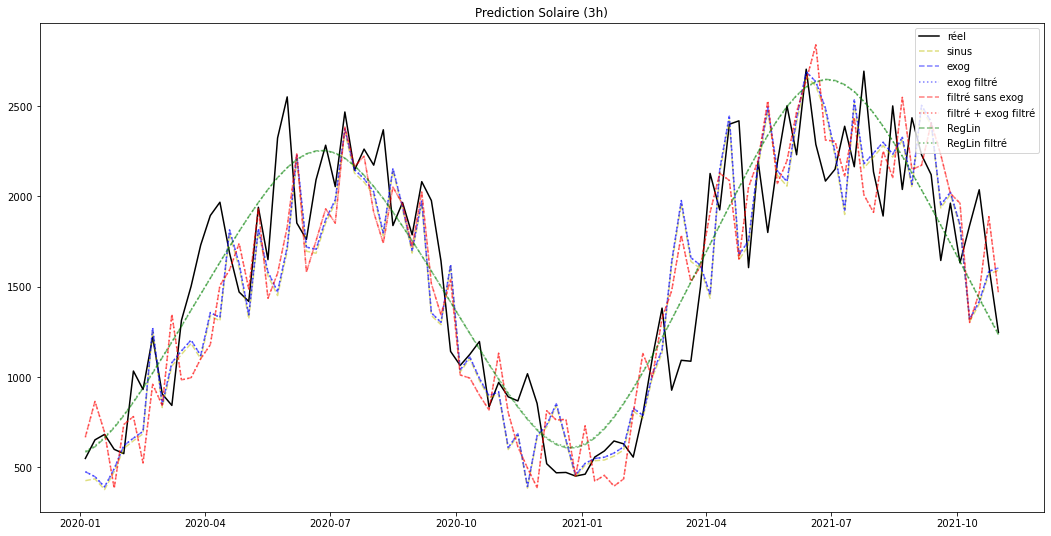

In [84]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Solaire'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Sol_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus')
plt.plot(bilan['Sol_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Sol_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Sol_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Sol_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Sol_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Sol_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Solaire (3h)')
plt.savefig('./results/pred_solaire_3h.png');

# Synthèse des erreurs

In [85]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,1281.956103,1280.691915,1280.687999,1368.896365,1368.606194,1691.893050,1692.353934
std,1400.223762,1392.826602,1392.832744,1330.996145,1329.580045,1119.565733,1118.843057
min,0.001691,0.073268,0.061409,0.262790,0.211816,0.243283,1.684333
25%,79.933512,86.648477,86.602578,276.426573,277.419810,856.359544,857.111606
50%,715.419162,715.031589,715.063291,823.217255,827.137100,1522.456414,1523.802089
75%,2178.737420,2169.053831,2168.926697,2229.583265,2223.964207,2204.944119,2203.413259
max,6520.598489,6485.123526,6485.019677,6337.968289,6336.181939,6498.792562,6495.050436


In [86]:
bilan.to_csv('./results/bilan_solaire_3h.csv', sep = ';')
erreur.to_csv('./results/erreur_solaire_3h.csv', sep = ';')